In [59]:
# 전처리에 사용
import pandas as pd
import matplotlib as mpl
import matplotlib.pylab as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
# 머신러닝에 사용
from sklearn.model_selection import cross_validate
# 특성 중요도
from sklearn.inspection import permutation_importance
#훈련모델
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
# 훈련모델 평가를 위한 metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_confusion_matrix
# 한글폰트 설정
plt.rc("font", family = "Malgun Gothic")
# 마이너스값에 대한 기호표시
plt.rcParams["axes.unicode_minus"] = False

In [60]:
# 데이터 읽어 들이기
file_name = "./data/01_org/final_df.csv"
df_data = pd.read_csv(file_name)
df_data

,pH,Temp,Voltage,QC
0,2.15,43.15,19.74,0
1,2.08,40.13,18.01,0
2,2.18,43.46,18.73,0
3,1.99,41.72,16.75,0
4,1.85,43.65,18.02,0
...,...,...,...,...
50089,2.05,42.84,15.38,0
50090,1.91,42.64,19.08,0
50091,2.11,44.09,18.14,0
50092,1.92,43.95,17.96,0


In [61]:
# 훈련데이터(data, target) 생성 / 독립과 종속
data = df_data[["pH","Temp","Voltage"]].to_numpy() # 2차원
target = df_data["QC"].to_numpy() # 1차원
print(data.shape, target.shape)

(50094, 3) (50094,)


In [62]:
# 훈련데이터와 테스트데이터로 분리
train_input, test_input, train_target, test_target = train_test_split(data,target,
                                                                      test_size=0.2,random_state=42)
print(train_input.shape,train_target.shape)
print(test_input.shape,test_target.shape)

(40075, 3) (40075,)
(10019, 3) (10019,)


In [63]:
# 정규화(표준화)
# - minmax_scale, robust_scale, StandardScaler

In [64]:
# StandardScaler
# 객체생성
ss = StandardScaler()
# 훈련시키기 - 정규화 데이터 생성
ss.fit(train_input)
# 생성된 정규화 데이터로 변환
train_std_scaled = ss.transform(train_input)
test_std_scaled = ss.transform(test_input)
print(train_std_scaled.shape,test_std_scaled.shape)

(40075, 3) (10019, 3)


In [65]:
# minmax_scale
# 객체생성
mm = MinMaxScaler()
# 훈련시키기 - 정규화 데이터 생성
mm.fit(train_input)
# 생성된 정규화 데이터로 변환
train_mm_scaled = mm.transform(train_input)
test_mm_scaled = mm.transform(test_input)
print(train_mm_scaled.shape,test_mm_scaled.shape)

(40075, 3) (10019, 3)


In [66]:
# robust_scale
# 객체생성
rs = RobustScaler()
# 훈련시키기 - 정규화 데이터 생성
rs.fit(train_input)
# 생성된 정규화 데이터로 변환
train_rs_scaled = rs.transform(train_input)
test_rs_scaled = rs.transform(test_input)
print(train_rs_scaled.shape,test_rs_scaled.shape)

(40075, 3) (10019, 3)


In [67]:
# 훈련하기

# 랜덤포레스트 훈련하기
rf = RandomForestClassifier(n_jobs=-1,random_state=42)
rf.fit(train_std_scaled,train_target)
print("훈련정확도 : ",rf.score(train_std_scaled,train_target))
print("테스트정확도 : ",rf.score(test_std_scaled,test_target))

# 예측하기
y_pred = rf.predict(test_std_scaled)
print("Accuracy(테스트 정확도) : ", accuracy_score(test_target,y_pred))
print("Precision(정밀도) : ", precision_score(test_target,y_pred))
print("Recall(재현율) : ", recall_score(test_target,y_pred))
print("F1_score(F1스코어) : ", f1_score(test_target,y_pred))

# 1에 가까울수록 좋음

훈련정확도 :  0.999825327510917
테스트정확도 :  0.9871244635193133
Accuracy(테스트 정확도) :  0.9871244635193133
Precision(정밀도) :  0.0
Recall(재현율) :  0.0
F1_score(F1스코어) :  0.0


C:\Users\Administrator\anaconda3\envs\pknu_base\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


C:\Users\Administrator\anaconda3\envs\pknu_base\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<Figure size 3000x3000 with 0 Axes>

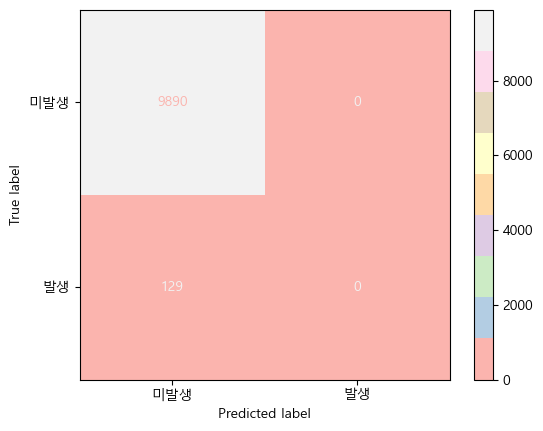

In [68]:
# 평가 매트릭스
plt.figure(figsize=(30,30))
plot_confusion_matrix(rf,test_std_scaled,test_target,
                      include_values=True,
                      display_labels=["미발생","발생"],
                      cmap="Pastel1")


In [69]:
# 하이퍼파라미터 튜닝 - 트리기반의 튜닝 진행
# 1. 학습에 사용할 트리 개수 선정
# - 기본값 설정
n_estimator_min = 1
n_estimator_max = 30
# 트리의 개수를 5씩 증가된 30개 만들기
param_n_tree = [n_tree * 5 for n_tree in range(n_estimator_min,n_estimator_max)]
for v_n_estimators in param_n_tree:
    model = RandomForestClassifier(n_estimators=v_n_estimators,random_state=42)
    model.fit(train_std_scaled,train_target)
    print("훈련정확도 : 테스트정확도 = ",
          v_n_estimators, 
          round(model.score(train_std_scaled,train_target),4),
          round(model.score(test_std_scaled,test_target),4),
          round(model.score(train_std_scaled,train_target) - model.score(test_std_scaled,test_target),4))
# 과대적합이 일어나지 않고 서로 가까운 지점 찾기

훈련정확도 : 테스트정확도 =  5 0.9968 0.9862 0.0105
훈련정확도 : 테스트정확도 =  10 0.9967 0.9872 0.0095
훈련정확도 : 테스트정확도 =  15 0.9986 0.9869 0.0116
훈련정확도 : 테스트정확도 =  20 0.9985 0.987 0.0115
훈련정확도 : 테스트정확도 =  25 0.9993 0.9869 0.0124
훈련정확도 : 테스트정확도 =  30 0.9992 0.9869 0.0123
훈련정확도 : 테스트정확도 =  35 0.9996 0.9869 0.0126
훈련정확도 : 테스트정확도 =  40 0.9995 0.9869 0.0125
훈련정확도 : 테스트정확도 =  45 0.9998 0.987 0.0127
훈련정확도 : 테스트정확도 =  50 0.9996 0.987 0.0126
훈련정확도 : 테스트정확도 =  55 0.9997 0.987 0.0126
훈련정확도 : 테스트정확도 =  60 0.9997 0.987 0.0127
훈련정확도 : 테스트정확도 =  65 0.9998 0.987 0.0128
훈련정확도 : 테스트정확도 =  70 0.9998 0.987 0.0128
훈련정확도 : 테스트정확도 =  75 0.9999 0.987 0.0128
훈련정확도 : 테스트정확도 =  80 0.9998 0.987 0.0128
훈련정확도 : 테스트정확도 =  85 0.9999 0.9872 0.0127
훈련정확도 : 테스트정확도 =  90 0.9999 0.9872 0.0127
훈련정확도 : 테스트정확도 =  95 0.9999 0.9871 0.0127
훈련정확도 : 테스트정확도 =  100 0.9998 0.9871 0.0127
훈련정확도 : 테스트정확도 =  105 0.9998 0.9872 0.0126
훈련정확도 : 테스트정확도 =  110 0.9999 0.9872 0.0127
훈련정확도 : 테스트정확도 =  115 0.9999 0.9872 0.0127
훈련정확도 : 테스트정확도 =  120 0.9999 0.9871 0.01

훈련정확도 : 테스트정확도 =  5 0.9968 0.9862 0.0105
훈련정확도 : 테스트정확도 =  10 0.9967 0.9872 0.0095
훈련정확도 : 테스트정확도 =  15 0.9986 0.9869 0.0116
훈련정확도 : 테스트정확도 =  20 0.9985 0.987 0.0115
훈련정확도 : 테스트정확도 =  25 0.9993 0.9869 0.0124
훈련정확도 : 테스트정확도 =  30 0.9992 0.9869 0.0123
훈련정확도 : 테스트정확도 =  35 0.9996 0.9869 0.0126
훈련정확도 : 테스트정확도 =  40 0.9995 0.9869 0.0125
훈련정확도 : 테스트정확도 =  45 0.9998 0.987 0.0127
훈련정확도 : 테스트정확도 =  50 0.9996 0.987 0.0126
훈련정확도 : 테스트정확도 =  55 0.9997 0.987 0.0126
훈련정확도 : 테스트정확도 =  60 0.9997 0.987 0.0127
훈련정확도 : 테스트정확도 =  65 0.9998 0.987 0.0128
훈련정확도 : 테스트정확도 =  70 0.9998 0.987 0.0128
훈련정확도 : 테스트정확도 =  75 0.9999 0.987 0.0128
훈련정확도 : 테스트정확도 =  80 0.9998 0.987 0.0128
훈련정확도 : 테스트정확도 =  85 0.9999 0.9872 0.0127
훈련정확도 : 테스트정확도 =  90 0.9999 0.9872 0.0127
훈련정확도 : 테스트정확도 =  95 0.9999 0.9871 0.0127
훈련정확도 : 테스트정확도 =  100 0.9998 0.9871 0.0127
훈련정확도 : 테스트정확도 =  105 0.9998 0.9872 0.0126
훈련정확도 : 테스트정확도 =  110 0.9999 0.9872 0.0127
훈련정확도 : 테스트정확도 =  115 0.9999 0.9872 0.0127
훈련정확도 : 테스트정확도 =  120 0.9999 0.9871 0.01

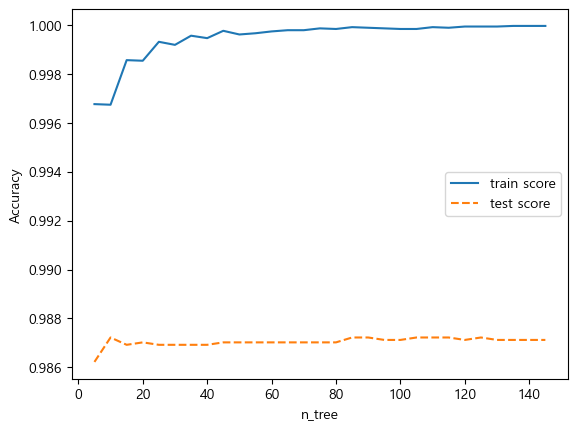

In [70]:
# 위 과정의 결과를 리스트에 저장
train_score = []
test_score = []
n_estimator_min = 1
n_estimator_max = 30
# 트리의 개수를 5씩 증가된 30개 만들기
param_n_tree = [n_tree * 5 for n_tree in range(n_estimator_min,n_estimator_max)]
for v_n_estimators in param_n_tree:
    model = RandomForestClassifier(n_estimators=v_n_estimators,random_state=42)
    model.fit(train_std_scaled,train_target)
    train_score.append(model.score(train_std_scaled,train_target))
    test_score.append(model.score(test_std_scaled,test_target))               
    print("훈련정확도 : 테스트정확도 = ",
          v_n_estimators, 
          round(model.score(train_std_scaled,train_target),4),
          round(model.score(test_std_scaled,test_target),4),
          round(model.score(train_std_scaled,train_target) - model.score(test_std_scaled,test_target),4))
                      
plt.plot(param_n_tree,train_score,linestyle="-",label="train score")
plt.plot(param_n_tree,test_score,linestyle="--",label="test score")
plt.xlabel("n_tree")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [71]:
# 테스트정확도가 높아지다가 낮아지즌 첫번째 시점의 트리개수를 사용
# - 과대/과소 적합이 없어야함
# - 트리개수 변수에 저장
# 10이 가장 최적
n_estimator =10

훈련정확도 : 테스트정확도 =  1 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  2 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  3 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  4 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  5 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  6 0.9878 0.9871 0.0007
훈련정확도 : 테스트정확도 =  7 0.988 0.9871 0.0008
훈련정확도 : 테스트정확도 =  8 0.9881 0.9872 0.0009
훈련정확도 : 테스트정확도 =  9 0.9882 0.9869 0.0013
훈련정확도 : 테스트정확도 =  10 0.9883 0.9872 0.0011
훈련정확도 : 테스트정확도 =  11 0.9886 0.9872 0.0014
훈련정확도 : 테스트정확도 =  12 0.9888 0.9872 0.0015
훈련정확도 : 테스트정확도 =  13 0.9889 0.9871 0.0017
훈련정확도 : 테스트정확도 =  14 0.989 0.9871 0.0018
훈련정확도 : 테스트정확도 =  15 0.9895 0.9872 0.0022
훈련정확도 : 테스트정확도 =  16 0.9899 0.9871 0.0027
훈련정확도 : 테스트정확도 =  17 0.9904 0.9872 0.0031
훈련정확도 : 테스트정확도 =  18 0.9917 0.9871 0.0046
훈련정확도 : 테스트정확도 =  19 0.9923 0.9872 0.0051
훈련정확도 : 테스트정확도 =  20 0.9932 0.9868 0.0063


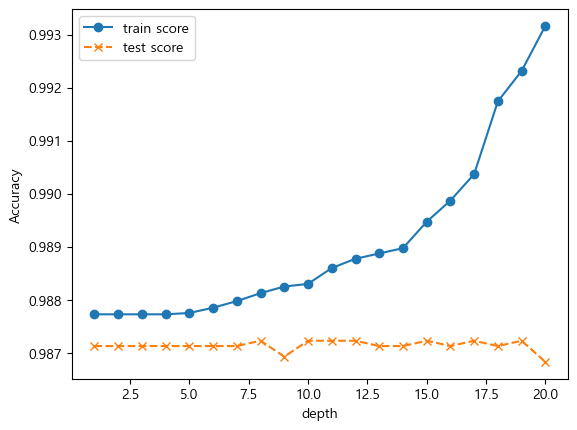

In [72]:
# 최대 깊이 선정
# 트리의 깊이 찾기(max_depth)

depth_min = 1
depth_max = 21

train_score = []
test_score = []

# 깊이찾기
param_depth = [depth for depth in range(depth_min,depth_max)]
for v_max_depth in param_depth:
    model = RandomForestClassifier(n_estimators=n_estimator,max_depth=v_max_depth,random_state=42)
    model.fit(train_std_scaled,train_target)
    train_score.append(model.score(train_std_scaled,train_target))
    test_score.append(model.score(test_std_scaled,test_target))               
    print("훈련정확도 : 테스트정확도 = ",
          v_max_depth, 
          round(model.score(train_std_scaled,train_target),4),
          round(model.score(test_std_scaled,test_target),4),
          round(model.score(train_std_scaled,train_target) - model.score(test_std_scaled,test_target),4))
                      
plt.plot(param_depth,train_score,linestyle="-",label="train score",marker="o")
plt.plot(param_depth,test_score,linestyle="--",label="test score",marker="x")
plt.xlabel("depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [73]:
# 깊이가 5 또는 9 정도에서 결정할 수 있으나, 과대적합이 발생하기전 깊이 5를 선정
# max_depth는 5로 결정 -> 트리의 깊이 결정
n_depth = 5

훈련정확도 : 테스트정확도 =  2 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  4 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  6 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  8 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  10 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  12 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  14 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  16 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  18 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  20 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  22 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  24 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  26 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  28 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  30 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  32 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  34 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  36 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  38 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  40 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  42 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  44 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  46 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  48 0.9877 0.9871 0.0

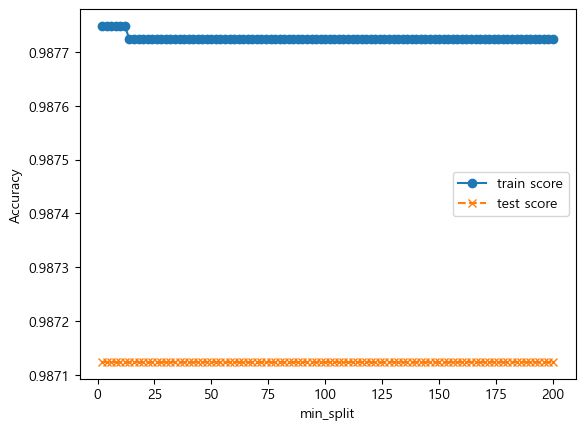

In [74]:
# 분리 노드의 최소 자료 수 선정

# 트리개수 저장
n_estimator = 10
# 트리 깊이 저장
n_depth = 5

n_split_min = 1
n_split_max = 101
# 최소자료수 범위 지정
train_score = []
test_score = []

# 깊이찾기
param_split = [n_split * 2 for n_split in range(n_split_min,n_split_max)]
for v_max_samples_split in param_split:
    model = RandomForestClassifier(n_estimators=n_estimator,max_depth=n_depth,min_samples_split=v_max_samples_split,random_state=42)
    model.fit(train_std_scaled,train_target)
    train_score.append(model.score(train_std_scaled,train_target))
    test_score.append(model.score(test_std_scaled,test_target))               
    print("훈련정확도 : 테스트정확도 = ",
          v_max_samples_split, 
          round(model.score(train_std_scaled,train_target),4),
          round(model.score(test_std_scaled,test_target),4),
          round(model.score(train_std_scaled,train_target) - model.score(test_std_scaled,test_target),4))
                      
plt.plot(param_split,train_score,linestyle="-",label="train score",marker="o")
plt.plot(param_split,test_score,linestyle="--",label="test score",marker="x")
plt.xlabel("min_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [75]:
# 분리노드의 최소자료수에 대한 값이 모두 동일(앞 빼고)
# 아무값이나 사용
# 8 또는 10중 사용
# 분리노드를 8로 결정
n_split = 8

훈련정확도 : 테스트정확도 =  2 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  4 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  6 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  8 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  10 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  12 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  14 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  16 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  18 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  20 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  22 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  24 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  26 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  28 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  30 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  32 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  34 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  36 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  38 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  40 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  42 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  44 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  46 0.9877 0.9871 0.0006
훈련정확도 : 테스트정확도 =  48 0.9877 0.9871 0.0

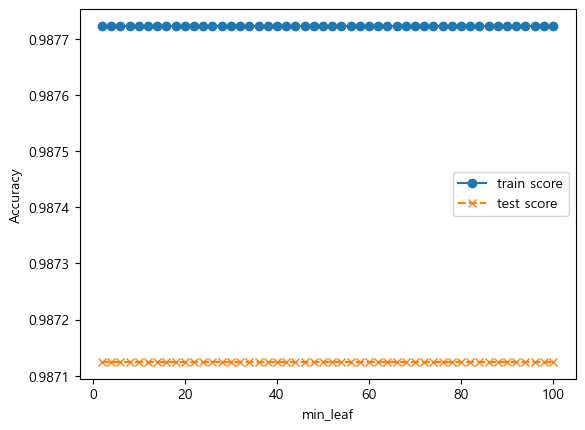

In [81]:
# 잎사귀 노드의 최소 자료수 선정

# 트리개수 저장
n_estimator = 10
# 트리 깊이 저장
n_depth = 5
# 분리노드 결정
n_split = 8

# 잎사귀 노드의 최소자료 수 범위 지정
n_leaf_min = 1
n_leaf_max = 51


train_score = []
test_score = []

# 깊이찾기
param_leaf = [n_leaf * 2 for n_leaf in range(n_leaf_min,n_leaf_max)]
for v_min_samples_leaf in param_leaf:
    model = RandomForestClassifier(n_estimators=n_estimator,max_depth=n_depth,min_samples_split=n_split,min_samples_leaf=v_min_samples_leaf,random_state=42)
    model.fit(train_std_scaled,train_target)
    train_score.append(model.score(train_std_scaled,train_target))
    test_score.append(model.score(test_std_scaled,test_target))               
    print("훈련정확도 : 테스트정확도 = ",
          v_min_samples_leaf, 
          round(model.score(train_std_scaled,train_target),4),
          round(model.score(test_std_scaled,test_target),4),
          round(model.score(train_std_scaled,train_target) - model.score(test_std_scaled,test_target),4))
                      
plt.plot(param_leaf,train_score,linestyle="-",label="train score",marker="o")
plt.plot(param_leaf,test_score,linestyle="--",label="test score",marker="x")
plt.xlabel("min_leaf")
plt.ylabel("Accuracy")
plt.legend()

# 그래프 저장하기
plt.savefig("./figure/rf_std_min_sample_leaf.png")
plt.show()



In [77]:
# 잎사귀 노드의 최소자료수도 동일한값
# 임의의 값 선정 : 8로 지정
# 잎사귀 노드의 최소 자료수 지정
n_leaf = 8

In [78]:

# 트리개수 저장
n_estimator = 10
# 트리 깊이 저장
n_depth = 5
# 분리노드 결정
n_split = 8
# 잎사귀 노드의 최소 자료수 지정
n_leaf = 8

In [79]:
# 모델생성하기
model = RandomForestClassifier(n_estimators=n_estimator,
                               max_depth=n_depth,
                               min_samples_split=n_split,
                               min_samples_leaf=n_leaf,
                               random_state=42)
# 훈련시키기
model.fit(train_std_scaled,train_target)

print("훈련정확도 : ",model.score(train_std_scaled,train_target))
print("테스트정확도 : ",model.score(test_std_scaled,test_target))

# 예측하기
y_pred = model.predict(test_std_scaled)
print("Accuracy(테스트 정확도) : ", accuracy_score(test_target,y_pred))
print("Precision(정밀도) : ", precision_score(test_target,y_pred))
print("Recall(재현율) : ", recall_score(test_target,y_pred))
print("F1_score(F1스코어) : ", f1_score(test_target,y_pred))

훈련정확도 :  0.9877230193387398
테스트정확도 :  0.9871244635193133
Accuracy(테스트 정확도) :  0.9871244635193133
Precision(정밀도) :  0.0
Recall(재현율) :  0.0
F1_score(F1스코어) :  0.0


C:\Users\Administrator\anaconda3\envs\pknu_base\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [80]:
# 모델 저장하기
import pickle
model_path = "./model/rf_std_model.pkl"
with open(model_path,"wb") as f:
    pickle.dump(model,f)

In [82]:
# 모델 불러오기
with open(model_path,"rb") as f:
    loaded_model = pickle.load(f)
    
print(loaded_model.score(test_std_scaled,test_target))
print(loaded_model.predict(test_std_scaled))

0.9871244635193133
[0 0 0 ... 0 0 0]


In [83]:
# 모델 저장방법
import joblib
model_path = "./model/rf_std_model2.pkl"
joblib.dump(model,model_path)

['./model/rf_std_model2.pkl']

In [84]:
# 모델 불러오기
loaded_model = joblib.load(model_path)
print(loaded_model.score(test_std_scaled,test_target))
print(loaded_model.predict(test_std_scaled))

0.9871244635193133
[0 0 0 ... 0 0 0]
